# Section 6.2.3: Dynamic-DeepHit Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo coves how to implement Dynamic-DeepHit with competing risks (Lee et al., 2019) using PyTorch (based on code by Vincent Jeanselme: https://github.com/Jeanselme/DynamicDeepHit). For an overview of how Dynamic-DeepHit works, please see Section 6.2.3 of the monograph. This demo builds off the DeepHit (competing events) demo (`S6.1.4_DeepHit_competing.ipynb`), so please look at that first. We again use the PBC dataset (Fleming and Harrington, 1991), for which the first event is "death" and the second is "transplanted". We now treat the PBC dataset as a variable-length time series dataset.

**Important**: In this demo, to avoid confusion in terminology, we use "time" to refer to different points in time of a time series, whereas we use "duration" to refer to the time-to-event outcome of interest, measured starting from the last time step per time series (refer to Sections 6.2.1 and 6.2.2 in the monograph for details). Note that for simplicity, we do *not* implement any of the strategies mentioned in "Practical considerations" at the end of Section 6.2.3 of the monograph.

*Disclaimer*: Note that Jeanselme's code uses various conventions specific to the `auton-survival` package. Our demo here intentionally tries to stick to what would be considered standard PyTorch conventions (so that as a warning up front, what we present here does not perfectly align with `auton-survival` demos but will more closely resemble how PyTorch is commonly used in many other settings, including for instance how model training works in TorchSurv). In particular, our demo here will expose some of the under the hood code logic as to make some preprocessing and model training steps more transparent (so that making modifications to any part of these should be more straightforward).

### Loading in the PBC dataset (Fleming and Harrington, 1991)

We begin by defining the training, validation, and test sets. Note that many variables are initially stored as Python lists to accommodate time series having varying lengths.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_list, Y_full_train_list, D_full_train_list, \
        X_test_raw_list, Y_test_list, D_test_list, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('pbc', competing=True,
                                                                             time_series=True)

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_list, X_val_raw_list, Y_train_list, Y_val_list, D_train_list, D_val_list = \
    train_test_split(X_full_train_raw_list, Y_full_train_list, D_full_train_list,
                     test_size=.2, random_state=0)

print(f'Training set size {len(X_train_raw_list)}')
print(f'Validation set size {len(X_val_raw_list)}')
print(f'Test set size {len(X_test_raw_list)}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 174
Validation set size 44
Test set size 94

Features before preprocessing (15 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'histologic', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'age']

Features after preprocessing (17 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'histologic_norm', 'serBilir_std', 'serChol_std', 'albumin_std', 'alkaline_std', 'SGOT_std', 'platelets_std', 'prothrombin_std', 'age_std', 'edema_no', 'edema_yes_despite_diuretics', 'edema_yes_without_diuretics']

Events: ['death', 'transplanted']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_list, preprocessor = build_preprocessor_and_preprocess(X_train_raw_list)
X_val_list = apply_preprocessor(X_val_raw_list, preprocessor)

### Discretizing *durations* (i.e., discretizing time-to-event outcomes)

Recall that in earlier demos in which we discretized the time-to-event outcome, we had used PyCox's discretization code. Although we could reuse PyCox's discretization code here as well, instead we shall use discretization code from Jeanselme's `DynamicDeepHit` GitHub repository.

In [3]:
import numpy as np

# ----------------------------------------------------------------------
# This snippet of code is taken from the `discretize` function (inside
# the DynamicDeepHit class) from here (where we have removed `self`
# since we now define this function outside of a Python class):
# https://github.com/Jeanselme/DynamicDeepHit/blob/main/ddh/ddh_api.py
def discretize(t, split, split_time=None):
    """
        Discretize the survival horizon

        Args:
            t (List of Array): Time of events
            split (int): Number of bins
            split_time (List, optional): List of bins (must be same length than split). Defaults to None.

        Returns:
            List of Array: Disretized events time
    """
    if split_time is None:
        _, split_time = np.histogram(np.concatenate(t), split - 1)
    t_discretized = np.array([np.digitize(t_, split_time, right = True) - 1 for t_ in t], dtype = object)
    return t_discretized, split_time
# ----------------------------------------------------------------------

num_durations = 16  # set this to 0 to use all unique durations in which any critical event happens

# discretize training durations
if num_durations == 0:
    # manually specify the duration grid
    Y_train_stacked_np = np.concatenate(Y_train_list)
    D_train_stacked_np = np.concatenate(D_train_list)
    mask = (D_train_stacked_np >= 1)  # boolean mask specifying which training points were not censored
    duration_grid_train_np = np.unique(Y_train_stacked_np[:, 0][mask])

    # the `discretize` function allows us to supply it with a pre-specified grid
    Y_train_discrete_np, _ = \
        discretize(Y_train_list,
                   len(duration_grid_train_np) - 1,
                   duration_grid_train_np)
else:
    Y_train_discrete_np, duration_grid_train_np \
        = discretize(Y_train_list, num_durations)

# discretize validation observed durations using the grid obtained based on training data
Y_val_discrete_np, _ = discretize(Y_val_list,
                                  len(duration_grid_train_np) - 1,
                                  duration_grid_train_np)

output_num_durations = len(duration_grid_train_np)
print(f'Number of discretized durations to be used with Dynamic-DeepHit: {output_num_durations}')
print('Duration grid:', duration_grid_train_np)

Number of discretized durations to be used with Dynamic-DeepHit: 16
Duration grid: [2.73792585e-03 9.56266224e-01 1.90979445e+00 2.86332273e+00
 3.81685114e+00 4.77037954e+00 5.72390747e+00 6.67743587e+00
 7.63096428e+00 8.58449268e+00 9.53802109e+00 1.04915495e+01
 1.14450769e+01 1.23986053e+01 1.33521338e+01 1.43056622e+01]


### Preparing training and validation sets for use with PyTorch

Since the different time series can vary in length, we use a standard approach for converting these to PyTorch tensors, which is to pad them so that they are the same length. Specifically, we first figure out what the maximum length is across training time series. Then for any training time series that is shorter than the maximum length, we add time steps at the end of them (so that there's a new feature vector full of NaNs for each of these new time steps) as to make sure that all training time series have the exact same length.

In [4]:
# ----------------------------------------------------------------------
# This snippet of code is taken from:
# https://github.com/autonlab/DeepSurvivalMachines/blob/c454774199c389e7bb9fa3077f153cdf4f1e7696/dsm/utilities.py
def _get_padded_features(x):
    """Helper function to pad variable length RNN inputs with nans."""
    d = max([len(x_) for x_ in x])
    padx = []
    for i in range(len(x)):
        pads = np.nan*np.ones((d - len(x[i]),) + x[i].shape[1:])
        padx.append(np.concatenate([x[i], pads]))
    return np.array(padx)
# ----------------------------------------------------------------------

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_padded = torch.from_numpy(_get_padded_features(X_train_list)).type(torch.float32).to(device)
X_train_padded.size()  # shape = (number of data points, max number of time steps, number of features per time step)

torch.Size([174, 16, 17])

Per data point, we only use the last time step's target label information (i.e., the last time step's duration (discretized already) and event indicator):

In [6]:
last_Y_train = torch.tensor([_[-1] for _ in Y_train_discrete_np]).type(torch.float32).to(device)
D_train = torch.tensor([_[-1] for _ in D_train_list]).type(torch.float32).to(device)
# each of these will be a 1D table with number of entries given by the number of data points

Now we put together the dataset that we will construct a PyTorch DataLoader object with:

In [7]:
train_data = list(zip(X_train_padded, last_Y_train, D_train))

Here's the code for prepping the validation data the same way:

In [8]:
X_val_padded = torch.from_numpy(_get_padded_features(X_val_list)).type(torch.float32).to(device)
last_Y_val = torch.tensor([_[-1] for _ in Y_val_discrete_np]).type(torch.float32).to(device)
D_val = torch.tensor([_[-1] for _ in D_val_list]).type(torch.float32).to(device)
val_data = list(zip(X_val_padded, last_Y_val, D_val))

### Setting up the Dynamic-DeepHit model and loss

We now set up a Dynamic-DeepHit model using Jeanselme's `DynamicDeepHitTorch` class.

In [9]:
import torch.nn as nn
from pycox.models import DeepHit

torch.manual_seed(0)

from ddh.ddh_torch import DynamicDeepHitTorch
from ddh.losses import total_loss

dropout = .3
rnn_type = 'LSTM'  # Jeanselme's code supports the options of 'RNN', 'LSTM', and 'GRU'
num_rnn_layers = 2
num_hidden = 8  # RNN hidden layer number of nodes (i.e., dimension of RNN hidden layer)

# number of nodes for different hidden layers in f_{next_time_step}
# (this is the neural net for predicting the next time step's feature vector
# as stated in Section 6.2.3 in the monograph; in Jeanselme's code, this
# neural net is called the "longitudinal network"
layers_for_predicting_next_time_step = [32, 32]

# number of nodes for different hidden layers in f_{attention}
# (this is the neural net for determining attention weights that are used
# in computing a summary vector from the RNN as described in Section 6.2.3
# in the monograph; in Jeanselme's code, this neural net is also called the
# attention network)
layers_for_attention = [8, 8]

# number of nodes for different hidden layers in each critical event's
# original DeepHit MLP (see the bottom right of Figure 6.1 in the
# monograph); in Jeanselme's code, these MLPs are called the cause-specific
# networks (where each critical event is thought of as a "cause")
layers_for_each_deephit_event = [8]

num_input_features = X_train_padded.size(2)
dynamic_deephit_model = \
    DynamicDeepHitTorch(num_input_features,
                        output_num_durations,
                        num_rnn_layers,
                        num_hidden,
                        long_param={'layers': layers_for_predicting_next_time_step,
                                    'dropout': dropout},
                        att_param={'layers': layers_for_attention,
                                   'dropout': dropout},
                        cs_param={'layers': layers_for_each_deephit_event,
                                  'dropout': dropout},
                        typ=rnn_type,
                        risks=len(events)).to(device)
dynamic_deephit_loss = total_loss

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

Jeanselme's Dynamic-DeepHit `total_loss` function views the loss function as:

$ \alpha\times\text{ranking loss} + \beta \times \text{negative log likelihood} + (1 - \alpha - \beta) \times \text{loss of prediction of next time steps' feature vectors}$,

where as a reminder, the ranking loss for DeepHit (and also Dynamic-DeepHit) has a hyperparameter $\sigma$ (see the loss function $L_{\text{DeepHit-ranking}}$ in Section 6.1.4 of the monograph; note that in the monograph, there is an additional hyperparameter $\eta$ that we are just treating as all ones).

The hyperparameters $\alpha$, $\beta$, and $\sigma$ are set below.

In [10]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

# Dynamic-DeepHit loss function hyperparameters
alpha = .8
beta = .1
sigma = .1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(dynamic_deephit_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    dynamic_deephit_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        X_batch = X_batch.to(device)
        # the `total_loss` function has been written so that it evalutes the model
        # for you, so there is no need to evaluate it ourselves prior to sending
        # the neural net's output to the loss function
        loss_batch = \
            total_loss(dynamic_deephit_model,
                       X_batch,
                       Y_batch,
                       D_batch,
                       alpha,
                       beta,
                       sigma)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    dynamic_deephit_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            X_batch = X_batch.to(device)
            batch_num_points = X_batch.size(0)
            train_loss += total_loss(dynamic_deephit_model,
                                     X_batch,
                                     Y_batch,
                                     D_batch,
                                     alpha,
                                     beta,
                                     sigma) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            X_batch = X_batch.to(device)
            batch_num_points = X_batch.size(0)
            val_loss += total_loss(dynamic_deephit_model,
                                   X_batch,
                                   Y_batch,
                                   D_batch,
                                   alpha,
                                   beta,
                                   sigma) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(dynamic_deephit_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
dynamic_deephit_model.load_state_dict(best_params)

Epoch 1 - train loss 247.502685546875 - val loss 82.81333923339844
Epoch 2 - train loss 250.00718688964844 - val loss 81.73088073730469
Epoch 3 - train loss 231.67796325683594 - val loss 80.12406158447266
Epoch 4 - train loss 225.209716796875 - val loss 77.67256164550781
Epoch 5 - train loss 212.74322509765625 - val loss 74.32438659667969
Epoch 6 - train loss 204.90618896484375 - val loss 70.28517150878906
Epoch 7 - train loss 193.29736328125 - val loss 65.89212799072266
Epoch 8 - train loss 184.64059448242188 - val loss 61.572078704833984
Epoch 9 - train loss 182.98582458496094 - val loss 57.86710739135742
Epoch 10 - train loss 178.58316040039062 - val loss 55.17209243774414
Epoch 11 - train loss 186.2574920654297 - val loss 53.3787841796875
Epoch 12 - train loss 173.02078247070312 - val loss 52.15653610229492
Epoch 13 - train loss 178.71426391601562 - val loss 51.44504165649414
Epoch 14 - train loss 169.9193878173828 - val loss 51.14988708496094
Epoch 15 - train loss 174.980819702148

<All keys matched successfully>

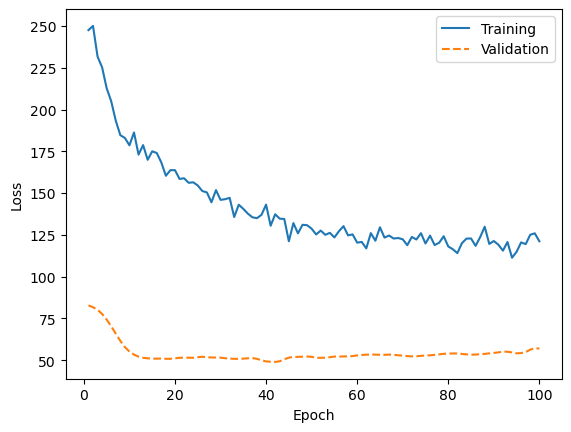

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting cumulative incidence functions (CIFs) on the test set

We begin by preprocessing the test data using the preprocessor built using training data.

In [12]:
X_test_list = apply_preprocessor(X_test_raw_list, preprocessor)
X_test_padded = torch.from_numpy(_get_padded_features(X_test_list)).type(torch.float32).to(device)
X_test_padded.size()

torch.Size([94, 16, 17])

We now get the neural net's output:

In [13]:
with torch.no_grad():
    # we ignore the 0th output, which contains predictions of next time steps' feature vectors
    _, pmf_test = dynamic_deephit_model(X_test_padded)
    # note that what comes out of the model is *not* the CIFs but instead the PMFs
    # (we can back out the CIFs from the PMFs)
# `pmf_test` will be a list with length given by the number of critical events (2 in this case)

Each event's predicted PMFs is stored as a 2D table with shape (number of test points, number of discrete durations)

In [14]:
pmf_test[0].size()

torch.Size([94, 16])

In [15]:
cifs = []
for event_idx_minus_one in range(len(pmf_test)):
    cifs.append(pmf_test[event_idx_minus_one].cumsum(1))

Importantly, the code is written so that it only makes a prediction at the very last time step per test time series. If you wanted to have a prediction as you saw more and more of a time series, you would have to write additional code (this would be straightforward in that you just give the model a truncated version of a test time series such as only the first time step of it, and then only the first two time steps of it, etc).

Note that given this setup where we only predict at the last time step per test time series, if we believe that having time 0 correspond to the last time step makes sense for this setup, then we could compute evaluation metrics the same way as we did for the DeepHit competing risks demo. We illustrate this below. Note that for simplicity, we rearrange `cifs` into the same format as what gets outputted by PyCox's DeepHit model; namely, we create a Python variable `cif_test_np` that is a Numpy array with shape (number of critical events, number of time steps in `duration_grid_train_np`, number of test points).

In [16]:
cif_test_np = np.array([cifs[event_idx_minus_one].cpu().numpy().T for event_idx_minus_one in range(len(events))])
cif_test_np.shape

(2, 16, 94)

Now we could reuse code from our earlier DeepHit (with competing risks) demo (although we now use the variable `duration_grid_train_np` instead of `time_grid_train_np`). For example, we plot test subject 0's CIFs for the two events:

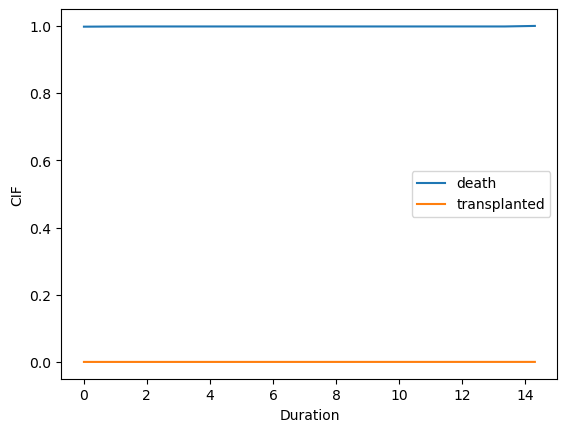

In [17]:
for event_idx_minus_one, event in enumerate(events):
    plt.plot(duration_grid_train_np, cif_test_np[event_idx_minus_one, :, 0], label=event)
plt.xlabel('Duration')
plt.ylabel('CIF')
plt.legend()

### Computing evaluation metrics on the test set

We take the ground truth information from the last time step per training and test point.

In [18]:
Y_train_np = np.array([_[-1] for _ in Y_train_list])
D_train_np = np.array([_[-1] for _ in D_train_list])
Y_test_np = np.array([_[-1] for _ in Y_test_list])
D_test_np = np.array([_[-1] for _ in D_test_list])
duration_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [19]:
import pandas as pd
from pycox.evaluation import EvalSurv

for event_idx_minus_one, event in enumerate(events):
    one_minus_cif_df = pd.DataFrame(1 - cif_test_np[event_idx_minus_one, :, :],
                                    index=duration_grid_train_np)

    # remember that in `Y_test_np`, the critical events are numbered starting from 1 and not 0
    eval_pycox = EvalSurv(one_minus_cif_df, Y_test_np, 1*(D_test_np == (event_idx_minus_one + 1)))

    C_td = eval_pycox.concordance_td('antolini')
    print(f'Event "{event}" - time-dependent concordance index: {C_td}')

Event "death" - time-dependent concordance index: 0.8275480059084195
Event "transplanted" - time-dependent concordance index: 0.5833333333333334


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

Note that the training data are specifically used to estimate the censoring distribution (for inverse probability of censoring weights -- the $w_i$ weights in equation (6.8) of the monograph), so it suffices to set the training event indicators to be 1 if *any* of the competing critical events happen, and 0 if censoring happens.

In [20]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(1*(D_train_np >= 1), Y_train_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_duration_indices = [int(.25 * len(duration_grid_test_np)),
                         int(.5 * len(duration_grid_test_np)),
                         int(.75 * len(duration_grid_test_np))]

for event_idx_minus_one, event in enumerate(events):
    # convert test labels into the structured array format used by scikit-survival
    labels_test_sksurv = Surv.from_arrays(1*(D_test_np == (event_idx_minus_one + 1)), Y_test_np)

    for eval_duration_index in eval_duration_indices:
        eval_duration = duration_grid_test_np[eval_duration_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_duration - duration_grid_train_np))
        cif_values_at_eval_duration_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, cif_values_at_eval_duration_np, tau=eval_duration)[0]
        print(f'Event "{event}" - eval time {eval_duration} - truncated time-dependent concordance: {concordance}')

Event "death" - eval time 0.27926841378211975 - truncated time-dependent concordance: 0.8213490371924643
Event "death" - eval time 0.8159018754959106 - truncated time-dependent concordance: 0.8173471650865896
Event "death" - eval time 2.17391300201416 - truncated time-dependent concordance: 0.8221068712460827
Event "transplanted" - eval time 0.27926841378211975 - truncated time-dependent concordance: 0.7607712261789206
Event "transplanted" - eval time 0.8159018754959106 - truncated time-dependent concordance: 0.5796577279937458
Event "transplanted" - eval time 2.17391300201416 - truncated time-dependent concordance: 0.5471388396655726


#### Brier score (Graf et al., 1999) generalized to competing risks

In [21]:
def compute_brier_competing(cif_values_at_time_horizon, censoring_kmf,
                            Y_test, D_test, event_of_interest, time_horizon):
    n = len(Y_test)
    assert len(D_test) == n

    residuals = np.zeros(n)
    for idx in range(n):
        observed_time = Y_test[idx]
        event_indicator = D_test[idx]
        if observed_time > time_horizon:
            weight = censoring_kmf.predict(time_horizon)
            residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
        else:
            weight = censoring_kmf.predict(observed_time)
            if event_indicator == event_of_interest:
                residuals[idx] = (1 - cif_values_at_time_horizon[idx])**2 / weight
            elif event_indicator != event_of_interest and event_indicator != 0:
                residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
    return residuals.mean()

import lifelines
censoring_kmf = lifelines.KaplanMeierFitter()
censoring_kmf.fit(Y_train_np, 1 * (D_train_np == 0))

for event_idx_minus_one, event in enumerate(events):
    for eval_duration_index in eval_duration_indices:
        eval_duration = duration_grid_test_np[eval_duration_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_duration - duration_grid_train_np))
        cif_values_at_eval_duration_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        brier = \
            compute_brier_competing(cif_values_at_eval_duration_np, censoring_kmf,
                                    Y_test_np, D_test_np, event_idx_minus_one + 1, eval_duration)
        print(f'Event "{event}" - eval time {eval_duration} - Brier score: {brier}')

Event "death" - eval time 0.27926841378211975 - Brier score: 0.3206562259142652
Event "death" - eval time 0.8159018754959106 - Brier score: 0.22173445175171386
Event "death" - eval time 2.17391300201416 - Brier score: 0.1322642842322594
Event "transplanted" - eval time 0.27926841378211975 - Brier score: 0.0908043482623298
Event "transplanted" - eval time 0.8159018754959106 - Brier score: 0.11615339725288878
Event "transplanted" - eval time 2.17391300201416 - Brier score: 0.10071478281278182
